(tax_smoothing_3)=
```{raw} html
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# How to Pay for a War: Part 3

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture deploys the quantecon library:

In [1]:
!pip install --upgrade quantecon

## Another Application of Markov Jump Linear Quadratic Dynamic Programming

This is another {doc}`sequel to an earlier lecture <tax_smoothing_1>`.

We again use a method introduced in lecture {doc}`Markov Jump LQ dynamic programming <markov_jump_lq>`
to implement some ideas Barro (1999 {cite}`barro1999determinants`, 2003 {cite}`barro2003religion`) that
extend his classic 1979 {cite}`Barro1979` model of tax smoothing.

Barro’s 1979 {cite}`Barro1979` model is about a government that borrows and lends in order
to help it minimize an intertemporal measure of distortions caused by
taxes.

Technically, Barro’s 1979 {cite}`Barro1979` model looks a lot like a consumption-smoothing model.

Our generalizations of his 1979 model will also look
like souped-up consumption-smoothing models.

In this lecture, we describe a  tax-smoothing problem of a
government that faces **roll-over risk**.

Let's start with some standard imports:

In [2]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Roll-Over Risk

Let $T_t$ denote tax collections, $\beta$ a discount factor,
$b_{t,t+1}$ time $t+1$ goods that the government promises to
pay at $t$, $G_t$ government purchases, $p^t_{t+1}$
the number of time $t$ goods received per time $t+1$ goods
promised.

The stochastic process of government expenditures is
exogenous.

The government’s problem is to choose a plan for borrowing
and tax collections $\{b_{t+1}, T_t\}_{t=0}^\infty$ to minimize

$$
E_0 \sum_{t=0}^\infty \beta^t T_t^2
$$

subject to the constraints

$$
T_t + p^t_{t+1} b_{t,t+1} = G_t + b_{t-1,t}
$$

$$
G_t = U_{g,t} z_t
$$

$$
z_{t+1} = A_{22,t} z_t + C_{2,t} w_{t+1}
$$

where $w_{t+1} \sim {\cal N}(0,I)$. The variables
$T_t, b_{t, t+1}$ are *control* variables chosen at $t$,
while $b_{t-1,t}$ is an endogenous state variable inherited from
the past at time $t$ and $p^t_{t+1}$ is an exogenous state
variable at time $t$.

This is the same set-up as used {doc}`in this lecture <tax_smoothing_1>`.

We will consider a situation in which the government faces “roll-over
risk”.

Specifically, we shut down the government’s ability to borrow in
one of the Markov states.

## A Dead End

A first thought for how to implement this might be to allow
$p^t_{t+1}$ to vary over time with:

$$
p^t_{t+1} = \beta
$$

in Markov state 1 and

$$
p^t_{t+1} = 0
$$

in Markov state 2.

Consequently, in the second Markov state, the
government is unable to borrow, and the budget constraint becomes
$T_t = G_t + b_{t-1,t}$.

However, if this is the only adjustment we make in our linear-quadratic
model, the government will not set $b_{t,t+1} = 0$, which is the
outcome we want to express *roll-over* risk in period $t$.

Instead, the government would have an incentive to set $b_{t,t+1}$
to a large negative number in state 2 – it would accumulate large
amounts of *assets* to bring into period $t+1$ because that is
cheap (Our Riccati equations will discover this for us!).

Thus, we must represent “roll-over risk” some other way.

## Better Representation of Roll-Over Risk

To force the government to set $b_{t,t+1} = 0$, we can instead
extend the model to have four Markov states:

1. Good today, good yesterday
1. Good today, bad yesterday
1. Bad today, good yesterday
1. Bad today, bad yesterday

where good is a state in which effectively the government can issue debt
and bad is a state in which effectively the government can’t issue debt.

We’ll explain what *effectively* means shortly.

We now set

$$
p^t_{t+1} = \beta
$$

in all states.

In addition – and this is important because it defines what we mean by
*effectively* -- we put a large penalty on the $b_{t-1,t}$
element of the state vector in states 2 and 4.

This will prevent the
government from wishing to issue any debt in states 3 or 4 because it
would experience a large penalty from doing so in the next period.

The transition matrix for this formulation is:

$$
\Pi = \begin{bmatrix} 0.95 & 0 & 0.05 & 0 \\
                         0.95 & 0 & 0.05 & 0 \\
                         0 & 0.9 & 0 & 0.1 \\
                         0 & 0.9 & 0 & 0.1 \\
\end{bmatrix}
$$

This transition matrix ensures that the Markov state cannot move, for
example, from state 3 to state 1.

Because state 3 is “bad today”, the next period cannot have “good yesterday”.

In [3]:
# Model parameters
β, Gbar, ρ, σ = 0.95, 5, 0.8, 1

# Basic model matrices
A22 = np.array([[1, 0], [Gbar, ρ], ])
C2 = np.array([[0], [σ]])
Ug = np.array([[0, 1]])

# LQ framework matrices
A_t = np.zeros((1, 3))
A_b = np.hstack((np.zeros((2, 1)), A22))
A = np.vstack((A_t, A_b))

B = np.zeros((3, 1))
B[0, 0] = 1

C = np.vstack((np.zeros((1, 1)), C2))

Sg = np.hstack((np.zeros((1, 1)), Ug))
S1 = np.zeros((1, 3))
S1[0, 0] = 1
S = S1 + Sg

R = S.T @ S

# Large penalty on debt in R2 to prevent borrowing in a bad state
R1 = np.copy(R)
R2 = np.copy(R)
R1[0, 0] = R[0, 0] + 1e-9
R2[0, 0] = R[0, 0] + 1e12

M = np.array([[-β]])
Q = M.T @ M
W = M.T @ S

Π = np.array([[0.95,   0, 0.05,   0],
              [0.95,   0, 0.05,   0],
              [0,    0.9,    0, 0.1],
              [0,    0.9,    0, 0.1]])

# Construct lists of matrices that correspond to each state
As = [A, A, A, A]
Bs = [B, B, B, B]
Cs = [C, C, C, C]
Rs = [R1, R2, R1, R2]
Qs = [Q, Q, Q, Q]
Ws = [W, W, W, W]

lqm = qe.LQMarkov(Π, Qs, Rs, As, Bs, Cs=Cs, Ns=Ws, beta=β)
lqm.stationary_values();

This model is simulated below, using the same process for $G_t$ as
in {doc}`this lecture <tax_smoothing_2>`.

When $p^t_{t+1} = \beta$
government debt fluctuates around zero.

The spikes in the series for
taxation show periods when the government is unable to access financial
markets: positive spikes occur when debt is positive, and the government
must raise taxes in the current period.

Negative spikes occur when the government has positive asset holdings.

An inability to use financial markets in the next period means that the
government uses those assets to lower taxation today.

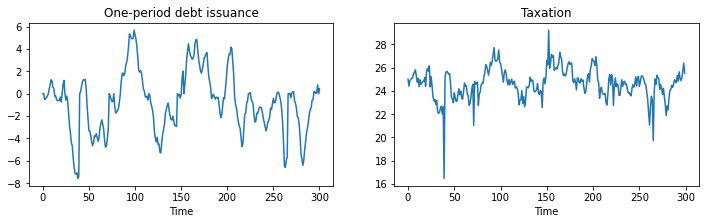

In [4]:
x0 = np.array([[0, 1, 25]])
T = 300
x, u, w, state = lqm.compute_sequence(x0, ts_length=T)

# Calculate taxation each period from the budget constraint and the Markov state
tax = np.zeros([T, 1])
for i in range(T):
    tax[i, :] = S @ x[:, i] + M @ u[:, i]

# Plot of debt issuance and taxation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(x[0, :])
ax1.set_title('One-period debt issuance')
ax1.set_xlabel('Time')
ax2.plot(tax)
ax2.set_title('Taxation')
ax2.set_xlabel('Time')
plt.show()

We can adjust the model so that, rather than having debt fluctuate
around zero, the government is a debtor in every period we allow it to
borrow.

To accomplish this, we simply raise $p^t_{t+1}$ to
$\beta + 0.02 = 0.97$.

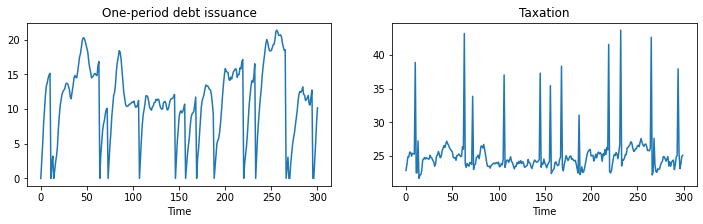

In [5]:
M = np.array([[-β - 0.02]])

Q = M.T @ M
W = M.T @ S

# Construct lists of matrices
As = [A, A, A, A]
Bs = [B, B, B, B]
Cs = [C, C, C, C]
Rs = [R1, R2, R1, R2]
Qs = [Q, Q, Q, Q]
Ws = [W, W, W, W]

lqm2 = qe.LQMarkov(Π, Qs, Rs, As, Bs, Cs=Cs, Ns=Ws, beta=β)
x, u, w, state = lqm2.compute_sequence(x0, ts_length=T)

# Calculate taxation each period from the budget constraint and the
# Markov state
tax = np.zeros([T, 1])
for i in range(T):
    tax[i, :] = S @ x[:, i] + M @ u[:, i]

# Plot of debt issuance and taxation
fig, (ax1, ax2) =  plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(x[0, :])
ax1.set_title('One-period debt issuance')
ax1.set_xlabel('Time')
ax2.plot(tax)
ax2.set_title('Taxation')
ax2.set_xlabel('Time')
plt.show()

With a lower interest rate, the government has an incentive to
increase debt over time.

However, with “roll-over risk”, debt is
recurrently reset to zero and taxes spike up.

Consequently, the
government is wary of letting debt get too high, due to the high costs of
a “sudden stop”.